## 6. How about weather prediction?
It is expected that machine learning will grow rapidly in the field of weather and climate science [6]. A one day deep learning Z500 forecast model is build, based on the work of Weyn , Durran and Caruana (2019) [7] (scaled down to keep the computational time under control). It is using a Long short-term memory (LSTM) neural network. LSTM networks are recurrent neural networks, which have feedback loops. So the output is not only depending on the input, as is the case with feedforward NN's, but also depends on previous inputs. They can be used for making predictions of time series. 

We first load the needed modules.

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import save_model, load_model
from keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from isoplot import isoplot
# Set location of data file
file="data/era20c.npy"

Our model will take as input the Z500 for 5 consecutive days (sequence_length) and will try to predict the Z500 for the 6<sup>th</sup> day. The "timeseries_dataset_from_array" is creating the 5 consecutive days input set and an output set with all the 6<sup>th</sup> days, out of the dataset with daily samples. 

In [2]:
# N is the size of the test and validation dataset
N = 2000
data = np.load(file)
data = data[:,:,:,1] # keep only Z500
data = data[..., np.newaxis]
test = data[:N//2]
val = data[N//2:N]
train = data[N:]
print(data.shape)
sequence_length = 5
batch_size = 256
train_in = train[:-sequence_length]
train_out = train[sequence_length:]
dataset_train = timeseries_dataset_from_array(train_in, train_out, 
                sequence_length=sequence_length, sequence_stride=1, batch_size=batch_size)
val_in = val[:-sequence_length]
val_out = val[sequence_length:]
dataset_val = timeseries_dataset_from_array(val_in, val_out, 
                sequence_length=sequence_length, sequence_stride=1, batch_size=batch_size)
test_in = test[:-sequence_length]
test_out = test[sequence_length:]
dataset_test = timeseries_dataset_from_array(test_in, test_out, 
                sequence_length=sequence_length, sequence_stride=1, batch_size=batch_size)

(40542, 32, 64, 1)


2022-06-26 10:26:00.775373: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The inputs for our model have a 5x32x64x1 shape: 5 consecutive days with a 32x64 Z500 grid and 1 channel (Z500). The first layer is a convolute LSTM layer with a 3x3 kernel and 16 channels as output. The number of hidden layer has been kept to a minimal for computational reasons. The output is the forecast, a 32x64 grid with 1 channel (Z500).

In [3]:
input = keras.Input(shape=(sequence_length, data.shape[1], data.shape[2], 1))
x = layers.ConvLSTM2D(16, (3, 3), activation='relu', padding='same')(input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

forecast = keras.Model(input, output)
forecast.compile(optimizer='adam', loss='MSE')
print(forecast.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 32, 64, 1)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 32, 64, 16)        9856      
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 64)        18496     
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 64, 64)       0         
 )                                                           

In [21]:
forecast.fit(dataset_train,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=dataset_val,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

forecast.save("data/forecast.h5")

Epoch 1/10
151/151 [==============================] - 1146s 8s/step - loss: 0.0102 - val_loss: 0.0030
Epoch 2/10
151/151 [==============================] - 1117s 7s/step - loss: 0.0027 - val_loss: 0.0021
Epoch 3/10
151/151 [==============================] - 1058s 7s/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/10
151/151 [==============================] - 1067s 7s/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/10
151/151 [==============================] - 1069s 7s/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/10
151/151 [==============================] - 1058s 7s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/10
151/151 [==============================] - 1052s 7s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/10
151/151 [==============================] - 1048s 7s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/10
151/151 [==============================] - 1052s 7s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/10
151/151 [==============================] - 1051s 7s/step - loss: 0.001

Let's evaluate the model with the test dataset.


In [4]:
forecast = load_model("data/forecast.h5")
score = forecast.evaluate(dataset_test, verbose=0)
print('Test loss:', score)

Test loss: 0.00125146156642586


Below you can set a date. The Z500 will be forecasted, given as input the Z500 of the 5 days before. The model is very basic and is built as a teaser for possible future work .  It is only based on Z500 input and is not performing very well (although no validation exercise has been done). Versions with more layers, parameters and variables are discussed in [7]. Machine learning models today are far from beating operational weather models, but are already superior to the classic models of the early 1950s. 

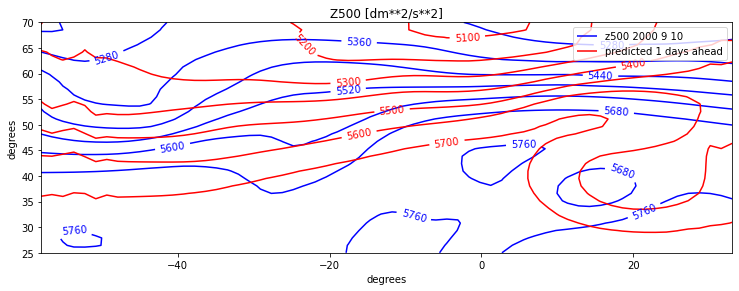

In [5]:
# Give here a date
date = "2000 9 10"

# We forecast 1 day ahead
days_ahead = 1

# load data
scale = np.load("data/scale.npy")
zone = np.load("data/zone.npy")
dates = np.load("data/dates.npy")
date_index = np.where(dates == date)[0][0]
x_in = data[date_index-days_ahead-sequence_length:date_index-days_ahead,...]

# predict
x_in = x_in[np.newaxis,...]
x_forecast = forecast.predict(x_in)
x_forecast = x_forecast.reshape(data.shape[1],data.shape[2])

# plot
isoplot(data[date_index,:,:,0],x_forecast,"z500 "+date,"predicted "+str(days_ahead)+ " days ahead",zone,scale[1]*10,"Z500 [dm**2/s**2]")